# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

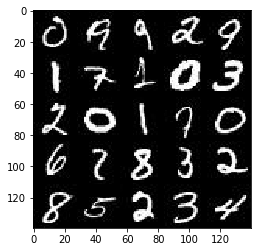

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

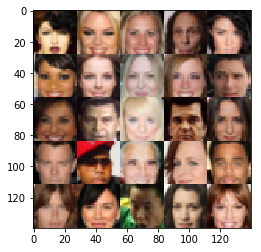

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='lr')
    


    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28*28*3 or 28*28*1
        x = tf.layers.conv2d(images, kernel_size= 5, filters=64, strides=2, padding='same', activation=None)
        x = tf.maximum(alpha*x, x)
        # size is (N,14,14,64)
        
        x = tf.layers.conv2d(x, kernel_size= 5, filters=128, strides=2, padding='same', activation=None)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha*x, x)
        # size is (N,7,7,128)
        
        x = tf.layers.conv2d(x, kernel_size= 5, filters=256, strides=1, padding='same', activation=None)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha*x, x)
        # size is (N,7,7,256)
        
        shape = x.get_shape().as_list()
        length = (shape[1]*shape[2]*shape[3])
        x = tf.reshape(x,(-1,length))
        # shape is (N,256*7*7)
        
        logits = tf.contrib.layers.fully_connected(x, 1, activation_fn=None)
        out = tf.nn.sigmoid(logits)
   
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x = tf.contrib.layers.fully_connected(z, 256*7*7, activation_fn=None)
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        x = tf.reshape(x, (-1, 7 ,7 ,256))
        # shape is now (N,7,7,256)
        
        x = tf.layers.conv2d_transpose(x, filters=128, kernel_size=5, strides=1, padding= 'same', activation=None)
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        # shape is now (N,7,7,128) 
        # output_shape = ceil(input_shape/stride) => 4 = input_shape/2 => input_shape = 8
        
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=5, strides=2, padding= 'same', activation=None)
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        # shape is now (N,14,14,64) 
        
        x = tf.layers.conv2d_transpose(x, filters=out_channel_dim, kernel_size=5, strides=2, padding= 'same', activation=None)
        # shape is now (N,28,28,out_channel_dim) 
        
        # Output layer, 32x32xout_channel_dim
        logits = x
        
        out = 0.5*tf.tanh(logits) # make the range from -.5 to .5
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function generator(z, out_channel_dim, is_train=True):
#      discriminator(images, reuse=False)
    g_model = generator(input_z, out_channel_dim) # This is like an fake image
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
#     print ([v.name for v in t_vars])
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

# Approach 1

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     tf.reset_default_graph()
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    samples, losses = [], []
    
    input_real, input_z, lr = model_inputs(image_width,image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    steps = 0
    print_every = 10
    show_every = 100
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1.
#                 print (steps)
                batch_z = np.random.uniform(-1., 1., size=(batch_size, z_dim))
                sess.run([d_train_opt, g_train_opt], feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    d_loss_train, g_loss_train = sess.run([d_loss, g_loss], 
                                              feed_dict={input_real: batch_images, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_loss_train),
                          "Generator Loss: {:.4f}".format(g_loss_train))
                    # Save losses to view after training
                    losses.append((d_loss_train, g_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                


                

# Approach 2
## Making inner loop of discriminator to run multiple times before running discriminator and generator together (just trying to see if there is an improvement in performance as mentioned in original paper from Goodfellow)
## Do not run the cell below if implementing the method in assignment (it'll overwrite the earlier definition of the funciton)

In [28]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     tf.reset_default_graph()
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    samples, losses = [], []
    
    input_real, input_z, lr = model_inputs(image_width,image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    steps = 0
    print_every = 10
    show_every = 100
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1.
#                 print (steps)
                batch_z = np.random.uniform(-1., 1., size=(batch_size, z_dim))
                
                for j in range(10):
                    sess.run([d_train_opt], feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                    
                sess.run([d_train_opt, g_train_opt], feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    d_loss_train, g_loss_train = sess.run([d_loss, g_loss], 
                                              feed_dict={input_real: batch_images, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_loss_train),
                          "Generator Loss: {:.4f}".format(g_loss_train))
                    # Save losses to view after training
                    losses.append((d_loss_train, g_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
                


                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [13]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

In [30]:
mnist_dataset.shape[0], mnist_dataset.image_mode

(60000, 'L')

# Implementation using Approach 1
## Run the cell under approach 1 before running this cell 

Epoch 1/2... Discriminator Loss: 0.0520... Generator Loss: 3.5315
Epoch 1/2... Discriminator Loss: 0.0006... Generator Loss: 8.2652
Epoch 1/2... Discriminator Loss: 0.3181... Generator Loss: 1.6640
Epoch 1/2... Discriminator Loss: 6.8565... Generator Loss: 0.0018
Epoch 1/2... Discriminator Loss: 0.4682... Generator Loss: 6.3132
Epoch 1/2... Discriminator Loss: 1.2370... Generator Loss: 4.1381
Epoch 1/2... Discriminator Loss: 0.1456... Generator Loss: 3.4196
Epoch 1/2... Discriminator Loss: 0.2284... Generator Loss: 4.4165
Epoch 1/2... Discriminator Loss: 0.3826... Generator Loss: 1.8352
Epoch 1/2... Discriminator Loss: 0.2715... Generator Loss: 2.2064


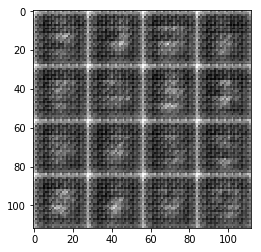

Epoch 1/2... Discriminator Loss: 0.3280... Generator Loss: 2.7462
Epoch 1/2... Discriminator Loss: 1.5427... Generator Loss: 0.4056
Epoch 1/2... Discriminator Loss: 1.7888... Generator Loss: 0.3139
Epoch 1/2... Discriminator Loss: 0.7660... Generator Loss: 0.9198
Epoch 1/2... Discriminator Loss: 0.5446... Generator Loss: 1.5060
Epoch 1/2... Discriminator Loss: 0.6656... Generator Loss: 1.2010
Epoch 1/2... Discriminator Loss: 0.6734... Generator Loss: 2.8515
Epoch 1/2... Discriminator Loss: 1.0623... Generator Loss: 0.6118
Epoch 1/2... Discriminator Loss: 3.2057... Generator Loss: 0.0746
Epoch 1/2... Discriminator Loss: 0.8873... Generator Loss: 0.8466


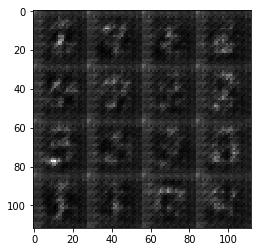

Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 3.3970
Epoch 1/2... Discriminator Loss: 0.6862... Generator Loss: 2.1098
Epoch 1/2... Discriminator Loss: 0.7616... Generator Loss: 0.9350
Epoch 1/2... Discriminator Loss: 0.7206... Generator Loss: 2.4427
Epoch 1/2... Discriminator Loss: 0.5786... Generator Loss: 1.5458
Epoch 1/2... Discriminator Loss: 0.7282... Generator Loss: 1.0301
Epoch 1/2... Discriminator Loss: 0.5973... Generator Loss: 2.0766
Epoch 1/2... Discriminator Loss: 0.6349... Generator Loss: 1.1671
Epoch 1/2... Discriminator Loss: 0.6285... Generator Loss: 1.0831
Epoch 1/2... Discriminator Loss: 0.4904... Generator Loss: 1.4857


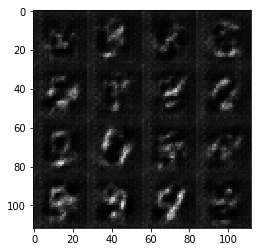

Epoch 1/2... Discriminator Loss: 1.7450... Generator Loss: 4.4694
Epoch 1/2... Discriminator Loss: 0.5441... Generator Loss: 1.6991
Epoch 1/2... Discriminator Loss: 1.9572... Generator Loss: 0.2011
Epoch 1/2... Discriminator Loss: 0.5176... Generator Loss: 1.3098
Epoch 1/2... Discriminator Loss: 0.5328... Generator Loss: 1.4893
Epoch 1/2... Discriminator Loss: 0.6120... Generator Loss: 1.1023
Epoch 1/2... Discriminator Loss: 0.4338... Generator Loss: 2.0439
Epoch 1/2... Discriminator Loss: 0.4561... Generator Loss: 2.1880
Epoch 1/2... Discriminator Loss: 0.4270... Generator Loss: 1.6151
Epoch 1/2... Discriminator Loss: 1.9234... Generator Loss: 0.2170


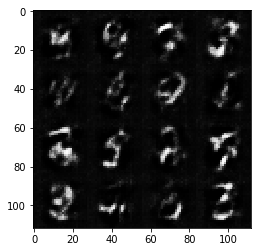

Epoch 1/2... Discriminator Loss: 0.5682... Generator Loss: 1.1070
Epoch 1/2... Discriminator Loss: 0.8102... Generator Loss: 0.7517
Epoch 1/2... Discriminator Loss: 0.4344... Generator Loss: 2.3693
Epoch 1/2... Discriminator Loss: 0.7398... Generator Loss: 0.9189
Epoch 1/2... Discriminator Loss: 0.7120... Generator Loss: 0.9385
Epoch 1/2... Discriminator Loss: 0.5788... Generator Loss: 2.1336
Epoch 1/2... Discriminator Loss: 0.4562... Generator Loss: 2.2982
Epoch 1/2... Discriminator Loss: 0.5500... Generator Loss: 1.4584
Epoch 1/2... Discriminator Loss: 0.5711... Generator Loss: 1.1736
Epoch 1/2... Discriminator Loss: 2.0713... Generator Loss: 0.1899


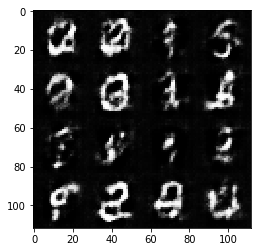

Epoch 1/2... Discriminator Loss: 0.8538... Generator Loss: 0.8225
Epoch 1/2... Discriminator Loss: 0.4043... Generator Loss: 1.8076
Epoch 1/2... Discriminator Loss: 0.4895... Generator Loss: 1.2604
Epoch 1/2... Discriminator Loss: 0.4762... Generator Loss: 1.6167
Epoch 1/2... Discriminator Loss: 0.5057... Generator Loss: 1.6766
Epoch 1/2... Discriminator Loss: 0.6212... Generator Loss: 1.0654
Epoch 1/2... Discriminator Loss: 0.7261... Generator Loss: 2.7100
Epoch 1/2... Discriminator Loss: 0.7473... Generator Loss: 0.9305
Epoch 1/2... Discriminator Loss: 0.5209... Generator Loss: 1.6303
Epoch 1/2... Discriminator Loss: 0.5626... Generator Loss: 1.9181


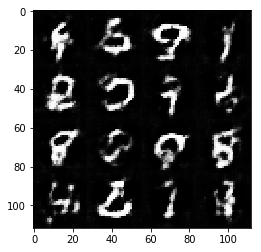

Epoch 1/2... Discriminator Loss: 2.0584... Generator Loss: 0.1983
Epoch 1/2... Discriminator Loss: 0.8621... Generator Loss: 0.7688
Epoch 1/2... Discriminator Loss: 0.4404... Generator Loss: 1.9437
Epoch 1/2... Discriminator Loss: 0.8021... Generator Loss: 0.8769
Epoch 1/2... Discriminator Loss: 1.0534... Generator Loss: 0.6272
Epoch 1/2... Discriminator Loss: 0.4662... Generator Loss: 1.4610
Epoch 1/2... Discriminator Loss: 0.4218... Generator Loss: 1.9242
Epoch 1/2... Discriminator Loss: 1.3278... Generator Loss: 0.4327
Epoch 1/2... Discriminator Loss: 0.6083... Generator Loss: 1.2690
Epoch 1/2... Discriminator Loss: 0.4819... Generator Loss: 1.4791


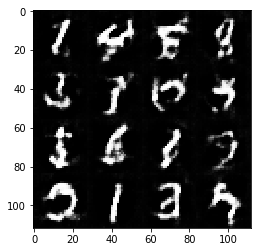

Epoch 1/2... Discriminator Loss: 0.4373... Generator Loss: 1.9111
Epoch 1/2... Discriminator Loss: 1.2906... Generator Loss: 4.3959
Epoch 1/2... Discriminator Loss: 0.5809... Generator Loss: 1.2721
Epoch 1/2... Discriminator Loss: 0.7774... Generator Loss: 0.8457
Epoch 1/2... Discriminator Loss: 0.4287... Generator Loss: 1.7932
Epoch 1/2... Discriminator Loss: 0.7608... Generator Loss: 0.9424
Epoch 1/2... Discriminator Loss: 0.5801... Generator Loss: 1.0260
Epoch 1/2... Discriminator Loss: 0.4987... Generator Loss: 1.5921
Epoch 1/2... Discriminator Loss: 0.4001... Generator Loss: 2.2929
Epoch 1/2... Discriminator Loss: 0.5518... Generator Loss: 1.3668


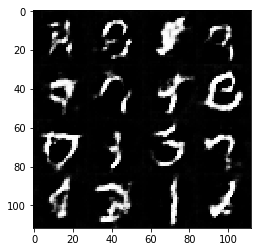

Epoch 1/2... Discriminator Loss: 1.3603... Generator Loss: 5.0074
Epoch 1/2... Discriminator Loss: 0.8098... Generator Loss: 2.3003
Epoch 1/2... Discriminator Loss: 0.5739... Generator Loss: 2.1403
Epoch 1/2... Discriminator Loss: 0.6068... Generator Loss: 1.1260
Epoch 1/2... Discriminator Loss: 0.7312... Generator Loss: 0.8663
Epoch 1/2... Discriminator Loss: 0.5890... Generator Loss: 1.1708
Epoch 1/2... Discriminator Loss: 0.8588... Generator Loss: 0.7350
Epoch 1/2... Discriminator Loss: 0.4822... Generator Loss: 1.4998
Epoch 1/2... Discriminator Loss: 0.7861... Generator Loss: 0.8247
Epoch 1/2... Discriminator Loss: 0.7371... Generator Loss: 0.9161


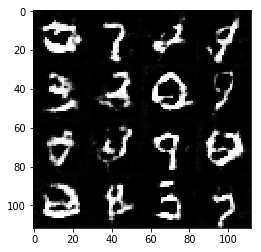

Epoch 1/2... Discriminator Loss: 0.9980... Generator Loss: 0.6371
Epoch 1/2... Discriminator Loss: 0.3799... Generator Loss: 2.1789
Epoch 1/2... Discriminator Loss: 0.3959... Generator Loss: 2.2916
Epoch 2/2... Discriminator Loss: 0.3723... Generator Loss: 1.8592
Epoch 2/2... Discriminator Loss: 0.9332... Generator Loss: 0.6660
Epoch 2/2... Discriminator Loss: 0.4371... Generator Loss: 1.4065
Epoch 2/2... Discriminator Loss: 0.5613... Generator Loss: 1.1712
Epoch 2/2... Discriminator Loss: 10.7320... Generator Loss: 13.5829
Epoch 2/2... Discriminator Loss: 0.5992... Generator Loss: 1.4055
Epoch 2/2... Discriminator Loss: 0.5148... Generator Loss: 1.2584


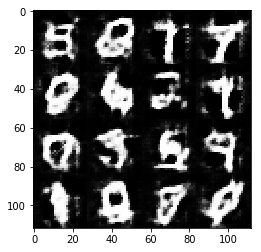

Epoch 2/2... Discriminator Loss: 0.5226... Generator Loss: 1.6120
Epoch 2/2... Discriminator Loss: 0.6664... Generator Loss: 1.0367
Epoch 2/2... Discriminator Loss: 0.5311... Generator Loss: 1.3409
Epoch 2/2... Discriminator Loss: 0.6465... Generator Loss: 1.0340
Epoch 2/2... Discriminator Loss: 0.4758... Generator Loss: 1.3698
Epoch 2/2... Discriminator Loss: 0.4809... Generator Loss: 1.3921
Epoch 2/2... Discriminator Loss: 0.9328... Generator Loss: 0.6913
Epoch 2/2... Discriminator Loss: 0.4657... Generator Loss: 1.4071
Epoch 2/2... Discriminator Loss: 0.5184... Generator Loss: 1.2279
Epoch 2/2... Discriminator Loss: 0.6104... Generator Loss: 1.0397


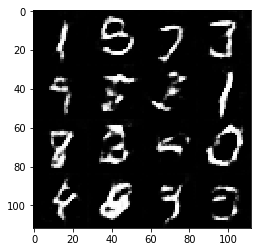

Epoch 2/2... Discriminator Loss: 3.1357... Generator Loss: 0.0820
Epoch 2/2... Discriminator Loss: 0.5602... Generator Loss: 1.2369
Epoch 2/2... Discriminator Loss: 0.3874... Generator Loss: 1.4963
Epoch 2/2... Discriminator Loss: 1.1083... Generator Loss: 0.5817
Epoch 2/2... Discriminator Loss: 0.5057... Generator Loss: 1.3185
Epoch 2/2... Discriminator Loss: 0.9486... Generator Loss: 0.6251
Epoch 2/2... Discriminator Loss: 0.4020... Generator Loss: 2.1998
Epoch 2/2... Discriminator Loss: 0.5883... Generator Loss: 1.1422
Epoch 2/2... Discriminator Loss: 0.6522... Generator Loss: 1.0256
Epoch 2/2... Discriminator Loss: 0.6366... Generator Loss: 0.9873


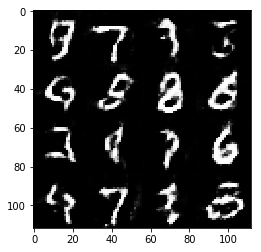

Epoch 2/2... Discriminator Loss: 0.7388... Generator Loss: 0.8402
Epoch 2/2... Discriminator Loss: 0.5305... Generator Loss: 1.1170
Epoch 2/2... Discriminator Loss: 0.6342... Generator Loss: 1.0382
Epoch 2/2... Discriminator Loss: 0.6758... Generator Loss: 0.9855
Epoch 2/2... Discriminator Loss: 0.5434... Generator Loss: 1.3384
Epoch 2/2... Discriminator Loss: 1.1538... Generator Loss: 0.5394
Epoch 2/2... Discriminator Loss: 0.5751... Generator Loss: 1.4085
Epoch 2/2... Discriminator Loss: 0.2762... Generator Loss: 2.6531
Epoch 2/2... Discriminator Loss: 0.5146... Generator Loss: 1.5995
Epoch 2/2... Discriminator Loss: 0.5510... Generator Loss: 1.2619


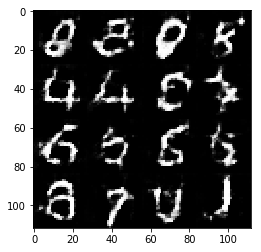

Epoch 2/2... Discriminator Loss: 0.7391... Generator Loss: 0.8591
Epoch 2/2... Discriminator Loss: 0.4851... Generator Loss: 1.2474
Epoch 2/2... Discriminator Loss: 1.0543... Generator Loss: 0.6265
Epoch 2/2... Discriminator Loss: 0.6736... Generator Loss: 1.0192
Epoch 2/2... Discriminator Loss: 0.5497... Generator Loss: 1.1051
Epoch 2/2... Discriminator Loss: 0.5697... Generator Loss: 1.1101
Epoch 2/2... Discriminator Loss: 0.9230... Generator Loss: 0.6533
Epoch 2/2... Discriminator Loss: 0.5466... Generator Loss: 1.1126
Epoch 2/2... Discriminator Loss: 1.2898... Generator Loss: 0.4136
Epoch 2/2... Discriminator Loss: 0.6970... Generator Loss: 3.3649


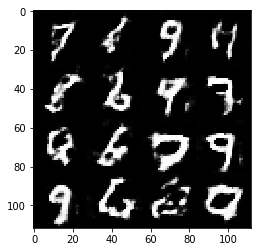

Epoch 2/2... Discriminator Loss: 0.3247... Generator Loss: 2.6942
Epoch 2/2... Discriminator Loss: 0.5393... Generator Loss: 1.4702
Epoch 2/2... Discriminator Loss: 0.5251... Generator Loss: 2.7716
Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.3794
Epoch 2/2... Discriminator Loss: 0.5742... Generator Loss: 1.1784
Epoch 2/2... Discriminator Loss: 0.4115... Generator Loss: 1.5463
Epoch 2/2... Discriminator Loss: 0.5357... Generator Loss: 1.2096
Epoch 2/2... Discriminator Loss: 0.8134... Generator Loss: 0.7589
Epoch 2/2... Discriminator Loss: 0.4735... Generator Loss: 1.2861
Epoch 2/2... Discriminator Loss: 0.7957... Generator Loss: 0.7869


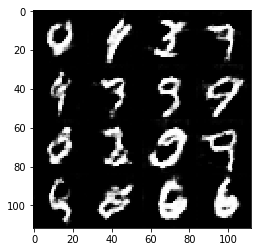

Epoch 2/2... Discriminator Loss: 0.7662... Generator Loss: 0.9216
Epoch 2/2... Discriminator Loss: 0.7721... Generator Loss: 0.9094
Epoch 2/2... Discriminator Loss: 0.4730... Generator Loss: 1.3028
Epoch 2/2... Discriminator Loss: 0.6752... Generator Loss: 0.9439
Epoch 2/2... Discriminator Loss: 0.9186... Generator Loss: 0.7458
Epoch 2/2... Discriminator Loss: 0.9699... Generator Loss: 3.7102
Epoch 2/2... Discriminator Loss: 0.7058... Generator Loss: 1.0514
Epoch 2/2... Discriminator Loss: 0.6480... Generator Loss: 1.3534
Epoch 2/2... Discriminator Loss: 0.6790... Generator Loss: 0.9534
Epoch 2/2... Discriminator Loss: 0.5005... Generator Loss: 1.4332


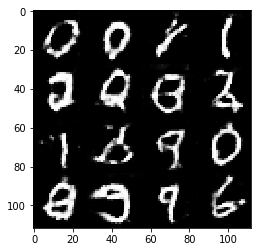

Epoch 2/2... Discriminator Loss: 0.5174... Generator Loss: 1.3759
Epoch 2/2... Discriminator Loss: 0.5308... Generator Loss: 1.2187
Epoch 2/2... Discriminator Loss: 0.6144... Generator Loss: 1.0904
Epoch 2/2... Discriminator Loss: 0.5852... Generator Loss: 1.0709
Epoch 2/2... Discriminator Loss: 3.2122... Generator Loss: 0.0688
Epoch 2/2... Discriminator Loss: 0.5234... Generator Loss: 2.4925
Epoch 2/2... Discriminator Loss: 0.3348... Generator Loss: 1.8560
Epoch 2/2... Discriminator Loss: 0.5739... Generator Loss: 1.0360
Epoch 2/2... Discriminator Loss: 1.1180... Generator Loss: 0.5156
Epoch 2/2... Discriminator Loss: 0.7664... Generator Loss: 0.8082


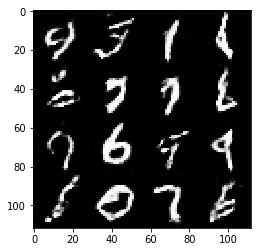

Epoch 2/2... Discriminator Loss: 0.7516... Generator Loss: 0.8247
Epoch 2/2... Discriminator Loss: 0.5209... Generator Loss: 1.1311
Epoch 2/2... Discriminator Loss: 0.8538... Generator Loss: 3.4240
Epoch 2/2... Discriminator Loss: 2.0879... Generator Loss: 0.2176
Epoch 2/2... Discriminator Loss: 0.9296... Generator Loss: 2.5852
Epoch 2/2... Discriminator Loss: 0.5508... Generator Loss: 1.5104
Epoch 2/2... Discriminator Loss: 0.9186... Generator Loss: 0.6946
Epoch 2/2... Discriminator Loss: 0.4234... Generator Loss: 1.7711
Epoch 2/2... Discriminator Loss: 1.2857... Generator Loss: 5.1644
Epoch 2/2... Discriminator Loss: 0.9426... Generator Loss: 0.7256


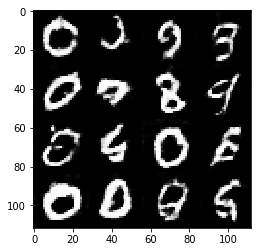

Epoch 2/2... Discriminator Loss: 0.8240... Generator Loss: 0.7606
Epoch 2/2... Discriminator Loss: 0.5933... Generator Loss: 1.2227
Epoch 2/2... Discriminator Loss: 0.7054... Generator Loss: 1.0074
Epoch 2/2... Discriminator Loss: 0.7770... Generator Loss: 0.8192
Epoch 2/2... Discriminator Loss: 1.0997... Generator Loss: 0.5445
Epoch 2/2... Discriminator Loss: 0.5811... Generator Loss: 1.0354
Epoch 2/2... Discriminator Loss: 0.5541... Generator Loss: 1.3220


In [14]:
batch_size = 64
z_dim = 100
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

# Training using approach 2 where inner loop (discriminator) runs several times (10) before one update of generator
## Implementation using approach 2
## Run the cell under Approach 2 and then run this cell

Epoch 1/2... Discriminator Loss: 1.3571... Generator Loss: 2.3651
Epoch 1/2... Discriminator Loss: 0.0928... Generator Loss: 4.6988
Epoch 1/2... Discriminator Loss: 0.6577... Generator Loss: 0.9672
Epoch 1/2... Discriminator Loss: 0.0799... Generator Loss: 3.0111
Epoch 1/2... Discriminator Loss: 0.2406... Generator Loss: 2.2615
Epoch 1/2... Discriminator Loss: 0.1866... Generator Loss: 2.4902
Epoch 1/2... Discriminator Loss: 0.1745... Generator Loss: 2.2804
Epoch 1/2... Discriminator Loss: 2.4723... Generator Loss: 0.4362
Epoch 1/2... Discriminator Loss: 0.3082... Generator Loss: 1.8774
Epoch 1/2... Discriminator Loss: 0.7909... Generator Loss: 0.8992


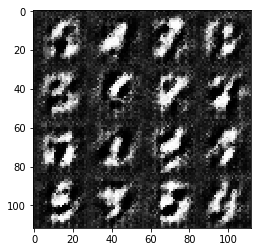

Epoch 1/2... Discriminator Loss: 0.1958... Generator Loss: 2.2512
Epoch 1/2... Discriminator Loss: 0.5476... Generator Loss: 1.1782
Epoch 1/2... Discriminator Loss: 0.1788... Generator Loss: 2.1544
Epoch 1/2... Discriminator Loss: 0.2266... Generator Loss: 1.9948
Epoch 1/2... Discriminator Loss: 0.1322... Generator Loss: 2.6003
Epoch 1/2... Discriminator Loss: 0.0760... Generator Loss: 3.0973
Epoch 1/2... Discriminator Loss: 0.0720... Generator Loss: 3.2656
Epoch 1/2... Discriminator Loss: 0.2771... Generator Loss: 3.2072
Epoch 1/2... Discriminator Loss: 0.1661... Generator Loss: 2.3226
Epoch 1/2... Discriminator Loss: 0.2692... Generator Loss: 2.0731


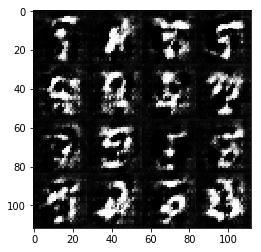

Epoch 1/2... Discriminator Loss: 0.1662... Generator Loss: 2.5692
Epoch 1/2... Discriminator Loss: 0.0614... Generator Loss: 3.3813
Epoch 1/2... Discriminator Loss: 0.0627... Generator Loss: 3.2462
Epoch 1/2... Discriminator Loss: 0.0649... Generator Loss: 3.5815
Epoch 1/2... Discriminator Loss: 0.0855... Generator Loss: 3.2615
Epoch 1/2... Discriminator Loss: 1.8628... Generator Loss: 0.6235
Epoch 1/2... Discriminator Loss: 0.1248... Generator Loss: 2.6733
Epoch 1/2... Discriminator Loss: 0.1134... Generator Loss: 2.9019
Epoch 1/2... Discriminator Loss: 0.1042... Generator Loss: 3.0310
Epoch 1/2... Discriminator Loss: 0.1568... Generator Loss: 2.6033


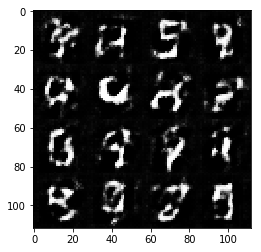

Epoch 1/2... Discriminator Loss: 0.1100... Generator Loss: 2.9303
Epoch 1/2... Discriminator Loss: 0.0697... Generator Loss: 3.4096
Epoch 1/2... Discriminator Loss: 0.1231... Generator Loss: 2.8702
Epoch 1/2... Discriminator Loss: 0.0837... Generator Loss: 3.2671
Epoch 1/2... Discriminator Loss: 0.1210... Generator Loss: 2.8248
Epoch 1/2... Discriminator Loss: 0.0812... Generator Loss: 3.4035
Epoch 1/2... Discriminator Loss: 0.1929... Generator Loss: 2.5833
Epoch 1/2... Discriminator Loss: 0.2273... Generator Loss: 2.2188
Epoch 1/2... Discriminator Loss: 0.1707... Generator Loss: 2.6842
Epoch 1/2... Discriminator Loss: 0.1266... Generator Loss: 3.0268


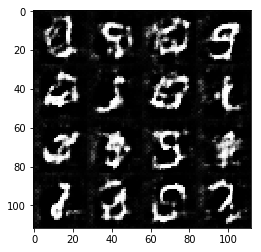

Epoch 1/2... Discriminator Loss: 0.2241... Generator Loss: 2.7122
Epoch 1/2... Discriminator Loss: 0.0794... Generator Loss: 3.5037
Epoch 1/2... Discriminator Loss: 0.1200... Generator Loss: 2.9252
Epoch 1/2... Discriminator Loss: 0.5797... Generator Loss: 1.5220
Epoch 1/2... Discriminator Loss: 0.4370... Generator Loss: 2.0721
Epoch 1/2... Discriminator Loss: 0.2953... Generator Loss: 1.7432
Epoch 1/2... Discriminator Loss: 0.1988... Generator Loss: 3.0265
Epoch 1/2... Discriminator Loss: 0.2380... Generator Loss: 2.4266
Epoch 1/2... Discriminator Loss: 0.1213... Generator Loss: 2.9209
Epoch 1/2... Discriminator Loss: 0.0901... Generator Loss: 3.4052


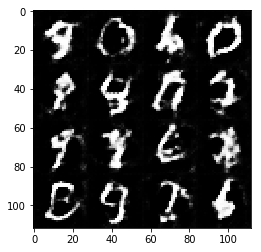

Epoch 1/2... Discriminator Loss: 0.1484... Generator Loss: 2.6655
Epoch 1/2... Discriminator Loss: 0.1979... Generator Loss: 2.4262
Epoch 1/2... Discriminator Loss: 0.2792... Generator Loss: 2.2973
Epoch 1/2... Discriminator Loss: 0.2354... Generator Loss: 2.5524
Epoch 1/2... Discriminator Loss: 0.2949... Generator Loss: 2.3320
Epoch 1/2... Discriminator Loss: 0.1984... Generator Loss: 2.2757
Epoch 1/2... Discriminator Loss: 0.2416... Generator Loss: 2.3637
Epoch 1/2... Discriminator Loss: 0.1500... Generator Loss: 2.5193
Epoch 1/2... Discriminator Loss: 0.5673... Generator Loss: 1.5223
Epoch 1/2... Discriminator Loss: 0.3266... Generator Loss: 2.0682


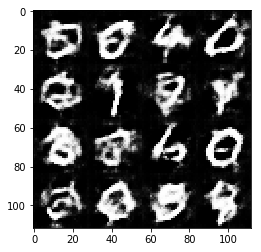

Epoch 1/2... Discriminator Loss: 0.5433... Generator Loss: 1.4624
Epoch 1/2... Discriminator Loss: 0.5121... Generator Loss: 1.6667
Epoch 1/2... Discriminator Loss: 0.5234... Generator Loss: 1.6104
Epoch 1/2... Discriminator Loss: 0.4048... Generator Loss: 2.1132
Epoch 1/2... Discriminator Loss: 0.6509... Generator Loss: 1.3690
Epoch 1/2... Discriminator Loss: 0.7638... Generator Loss: 1.7180
Epoch 1/2... Discriminator Loss: 0.7842... Generator Loss: 1.3256
Epoch 1/2... Discriminator Loss: 0.2810... Generator Loss: 2.0693
Epoch 1/2... Discriminator Loss: 0.4402... Generator Loss: 1.6267
Epoch 1/2... Discriminator Loss: 0.4487... Generator Loss: 1.8229


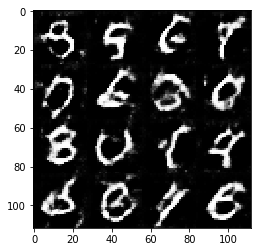

Epoch 1/2... Discriminator Loss: 0.2471... Generator Loss: 2.4182
Epoch 1/2... Discriminator Loss: 0.3677... Generator Loss: 1.8297
Epoch 1/2... Discriminator Loss: 0.4020... Generator Loss: 1.8501
Epoch 1/2... Discriminator Loss: 0.3973... Generator Loss: 1.8417
Epoch 1/2... Discriminator Loss: 0.4147... Generator Loss: 1.8717
Epoch 1/2... Discriminator Loss: 0.4326... Generator Loss: 2.0406
Epoch 1/2... Discriminator Loss: 0.5949... Generator Loss: 1.5727
Epoch 1/2... Discriminator Loss: 0.6449... Generator Loss: 1.5100
Epoch 1/2... Discriminator Loss: 0.8490... Generator Loss: 1.3305
Epoch 1/2... Discriminator Loss: 0.7894... Generator Loss: 1.3566


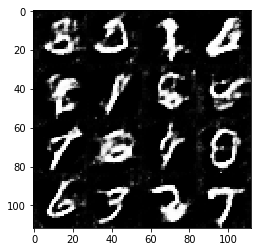

Epoch 1/2... Discriminator Loss: 0.1729... Generator Loss: 2.4581
Epoch 1/2... Discriminator Loss: 0.3452... Generator Loss: 2.0691
Epoch 1/2... Discriminator Loss: 0.7450... Generator Loss: 1.1545
Epoch 1/2... Discriminator Loss: 0.5643... Generator Loss: 1.6046
Epoch 1/2... Discriminator Loss: 0.3669... Generator Loss: 2.0305
Epoch 1/2... Discriminator Loss: 0.6526... Generator Loss: 1.7470
Epoch 1/2... Discriminator Loss: 0.4847... Generator Loss: 1.8273
Epoch 1/2... Discriminator Loss: 0.6916... Generator Loss: 1.3417
Epoch 1/2... Discriminator Loss: 0.4275... Generator Loss: 1.7854
Epoch 1/2... Discriminator Loss: 0.6920... Generator Loss: 1.3513


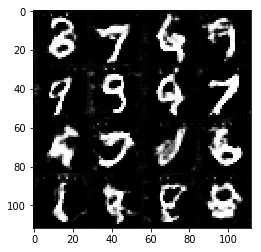

Epoch 1/2... Discriminator Loss: 0.4182... Generator Loss: 2.0319
Epoch 1/2... Discriminator Loss: 0.6264... Generator Loss: 1.4391
Epoch 1/2... Discriminator Loss: 0.5248... Generator Loss: 1.6728
Epoch 2/2... Discriminator Loss: 0.1863... Generator Loss: 2.2879
Epoch 2/2... Discriminator Loss: 0.5342... Generator Loss: 1.4041
Epoch 2/2... Discriminator Loss: 1.3327... Generator Loss: 0.9013
Epoch 2/2... Discriminator Loss: 0.4634... Generator Loss: 1.6482
Epoch 2/2... Discriminator Loss: 0.3777... Generator Loss: 2.1954
Epoch 2/2... Discriminator Loss: 0.4091... Generator Loss: 2.2290
Epoch 2/2... Discriminator Loss: 0.5929... Generator Loss: 1.6679


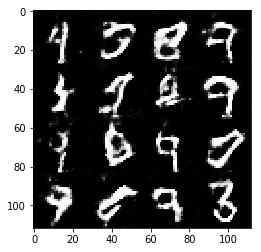

Epoch 2/2... Discriminator Loss: 0.5299... Generator Loss: 1.9837
Epoch 2/2... Discriminator Loss: 0.8056... Generator Loss: 1.5580
Epoch 2/2... Discriminator Loss: 0.4237... Generator Loss: 2.2192
Epoch 2/2... Discriminator Loss: 0.6861... Generator Loss: 1.7005
Epoch 2/2... Discriminator Loss: 0.4139... Generator Loss: 2.0509
Epoch 2/2... Discriminator Loss: 0.5391... Generator Loss: 1.6572
Epoch 2/2... Discriminator Loss: 0.4058... Generator Loss: 2.1058
Epoch 2/2... Discriminator Loss: 0.8305... Generator Loss: 1.3580
Epoch 2/2... Discriminator Loss: 0.8175... Generator Loss: 1.3957
Epoch 2/2... Discriminator Loss: 0.6464... Generator Loss: 1.7673


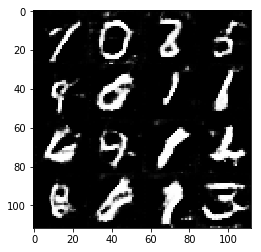

Epoch 2/2... Discriminator Loss: 1.3739... Generator Loss: 0.8040
Epoch 2/2... Discriminator Loss: 1.3143... Generator Loss: 0.6663
Epoch 2/2... Discriminator Loss: 0.3739... Generator Loss: 2.2850
Epoch 2/2... Discriminator Loss: 0.1025... Generator Loss: 3.0089
Epoch 2/2... Discriminator Loss: 0.0757... Generator Loss: 3.5257
Epoch 2/2... Discriminator Loss: 0.1168... Generator Loss: 2.9963
Epoch 2/2... Discriminator Loss: 0.1569... Generator Loss: 2.5957
Epoch 2/2... Discriminator Loss: 0.1384... Generator Loss: 2.6423
Epoch 2/2... Discriminator Loss: 0.2185... Generator Loss: 2.2372
Epoch 2/2... Discriminator Loss: 0.3858... Generator Loss: 1.6280


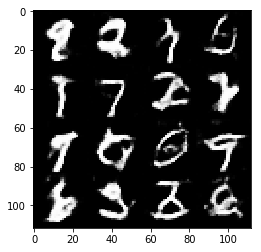

Epoch 2/2... Discriminator Loss: 0.2867... Generator Loss: 2.1258
Epoch 2/2... Discriminator Loss: 0.1409... Generator Loss: 2.6988
Epoch 2/2... Discriminator Loss: 0.2084... Generator Loss: 2.2141
Epoch 2/2... Discriminator Loss: 0.2900... Generator Loss: 2.4098
Epoch 2/2... Discriminator Loss: 0.2338... Generator Loss: 2.4983
Epoch 2/2... Discriminator Loss: 0.4195... Generator Loss: 1.8110
Epoch 2/2... Discriminator Loss: 0.4333... Generator Loss: 1.9463
Epoch 2/2... Discriminator Loss: 0.3253... Generator Loss: 2.3360
Epoch 2/2... Discriminator Loss: 0.3795... Generator Loss: 2.4678
Epoch 2/2... Discriminator Loss: 0.3546... Generator Loss: 2.3363


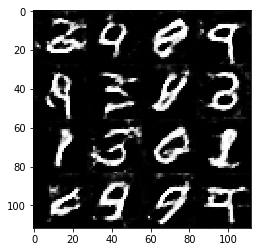

Epoch 2/2... Discriminator Loss: 1.1023... Generator Loss: 0.9769
Epoch 2/2... Discriminator Loss: 0.8801... Generator Loss: 1.1132
Epoch 2/2... Discriminator Loss: 0.5903... Generator Loss: 1.4458
Epoch 2/2... Discriminator Loss: 0.8314... Generator Loss: 1.3784
Epoch 2/2... Discriminator Loss: 0.5456... Generator Loss: 1.8552
Epoch 2/2... Discriminator Loss: 0.7261... Generator Loss: 1.9408
Epoch 2/2... Discriminator Loss: 1.1532... Generator Loss: 1.1178
Epoch 2/2... Discriminator Loss: 0.6763... Generator Loss: 1.8156
Epoch 2/2... Discriminator Loss: 0.9659... Generator Loss: 1.1760
Epoch 2/2... Discriminator Loss: 0.7873... Generator Loss: 1.6235


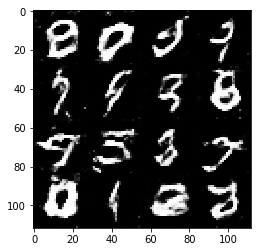

Epoch 2/2... Discriminator Loss: 0.9502... Generator Loss: 1.2779
Epoch 2/2... Discriminator Loss: 1.1005... Generator Loss: 1.3223
Epoch 2/2... Discriminator Loss: 0.6327... Generator Loss: 1.7032
Epoch 2/2... Discriminator Loss: 0.1989... Generator Loss: 2.7119
Epoch 2/2... Discriminator Loss: 0.1634... Generator Loss: 2.5848
Epoch 2/2... Discriminator Loss: 0.1056... Generator Loss: 2.9459
Epoch 2/2... Discriminator Loss: 0.0379... Generator Loss: 4.1506
Epoch 2/2... Discriminator Loss: 0.1292... Generator Loss: 3.1284
Epoch 2/2... Discriminator Loss: 0.2559... Generator Loss: 2.4808
Epoch 2/2... Discriminator Loss: 0.1885... Generator Loss: 2.6169


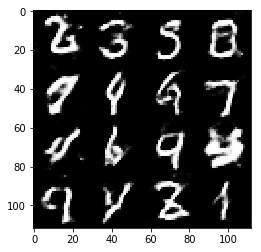

Epoch 2/2... Discriminator Loss: 0.1462... Generator Loss: 2.7127
Epoch 2/2... Discriminator Loss: 0.1417... Generator Loss: 2.5917
Epoch 2/2... Discriminator Loss: 0.0702... Generator Loss: 4.0639
Epoch 2/2... Discriminator Loss: 0.1948... Generator Loss: 2.6697
Epoch 2/2... Discriminator Loss: 0.4476... Generator Loss: 1.8859
Epoch 2/2... Discriminator Loss: 0.9272... Generator Loss: 1.0600
Epoch 2/2... Discriminator Loss: 0.6148... Generator Loss: 1.6041
Epoch 2/2... Discriminator Loss: 0.5596... Generator Loss: 1.7430
Epoch 2/2... Discriminator Loss: 0.9580... Generator Loss: 1.4810
Epoch 2/2... Discriminator Loss: 0.8631... Generator Loss: 1.5020


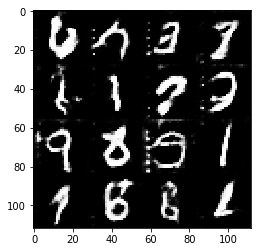

Epoch 2/2... Discriminator Loss: 0.5509... Generator Loss: 1.8552
Epoch 2/2... Discriminator Loss: 0.6287... Generator Loss: 1.6288
Epoch 2/2... Discriminator Loss: 0.5706... Generator Loss: 1.7208
Epoch 2/2... Discriminator Loss: 0.5869... Generator Loss: 1.9106
Epoch 2/2... Discriminator Loss: 0.9945... Generator Loss: 1.2963
Epoch 2/2... Discriminator Loss: 0.7803... Generator Loss: 1.5272
Epoch 2/2... Discriminator Loss: 1.1777... Generator Loss: 1.1146
Epoch 2/2... Discriminator Loss: 0.1197... Generator Loss: 3.0847
Epoch 2/2... Discriminator Loss: 0.0955... Generator Loss: 3.2369
Epoch 2/2... Discriminator Loss: 0.1190... Generator Loss: 3.0262


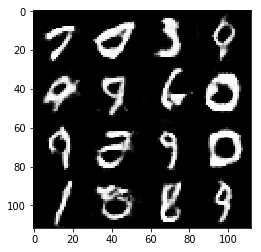

Epoch 2/2... Discriminator Loss: 0.0270... Generator Loss: 4.5210
Epoch 2/2... Discriminator Loss: 0.1799... Generator Loss: 3.0776
Epoch 2/2... Discriminator Loss: 0.3234... Generator Loss: 2.1982
Epoch 2/2... Discriminator Loss: 0.3426... Generator Loss: 1.8976
Epoch 2/2... Discriminator Loss: 0.1764... Generator Loss: 2.9318
Epoch 2/2... Discriminator Loss: 0.3850... Generator Loss: 2.0250
Epoch 2/2... Discriminator Loss: 0.5062... Generator Loss: 1.8952
Epoch 2/2... Discriminator Loss: 1.0581... Generator Loss: 1.1007
Epoch 2/2... Discriminator Loss: 0.6167... Generator Loss: 1.5176
Epoch 2/2... Discriminator Loss: 0.7862... Generator Loss: 1.2286


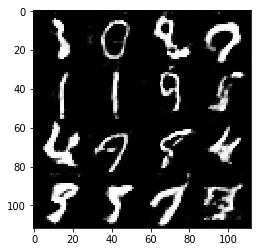

Epoch 2/2... Discriminator Loss: 0.9080... Generator Loss: 1.2352
Epoch 2/2... Discriminator Loss: 0.6717... Generator Loss: 1.7209
Epoch 2/2... Discriminator Loss: 1.1703... Generator Loss: 1.2156
Epoch 2/2... Discriminator Loss: 1.4946... Generator Loss: 0.8530
Epoch 2/2... Discriminator Loss: 1.0255... Generator Loss: 1.0532
Epoch 2/2... Discriminator Loss: 1.0263... Generator Loss: 1.0882
Epoch 2/2... Discriminator Loss: 0.6460... Generator Loss: 1.7881


In [18]:
batch_size = 64
z_dim = 100
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [22]:
celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))

# Train using approach 1 as mentioned in the assignment
## Run the cell under approach 1 first
## Implementation using approach 1

Epoch 1/1... Discriminator Loss: 0.1665... Generator Loss: 2.3900
Epoch 1/1... Discriminator Loss: 0.2721... Generator Loss: 1.6733
Epoch 1/1... Discriminator Loss: 0.0545... Generator Loss: 13.0686
Epoch 1/1... Discriminator Loss: 0.2526... Generator Loss: 20.9823
Epoch 1/1... Discriminator Loss: 0.0679... Generator Loss: 3.2229
Epoch 1/1... Discriminator Loss: 0.1927... Generator Loss: 3.1935
Epoch 1/1... Discriminator Loss: 0.0234... Generator Loss: 9.5274
Epoch 1/1... Discriminator Loss: 0.0823... Generator Loss: 3.5894
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 0.7105... Generator Loss: 1.1557


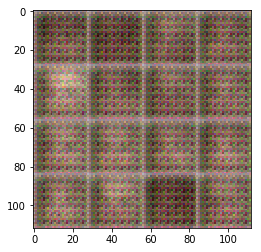

Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 0.5003... Generator Loss: 1.6037
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 0.8578... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.4269
Epoch 1/1... Discriminator Loss: 0.4994... Generator Loss: 1.2574
Epoch 1/1... Discriminator Loss: 0.4201... Generator Loss: 1.6557
Epoch 1/1... Discriminator Loss: 0.8553... Generator Loss: 5.8662
Epoch 1/1... Discriminator Loss: 0.2936... Generator Loss: 2.4908


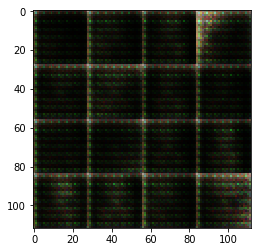

Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 5.0824
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 0.7182... Generator Loss: 1.0224
Epoch 1/1... Discriminator Loss: 0.7437... Generator Loss: 0.9893
Epoch 1/1... Discriminator Loss: 0.5214... Generator Loss: 2.6696
Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 2.4383
Epoch 1/1... Discriminator Loss: 0.4920... Generator Loss: 2.6371
Epoch 1/1... Discriminator Loss: 0.4682... Generator Loss: 2.3491
Epoch 1/1... Discriminator Loss: 2.5896... Generator Loss: 0.1290
Epoch 1/1... Discriminator Loss: 0.8060... Generator Loss: 4.1971


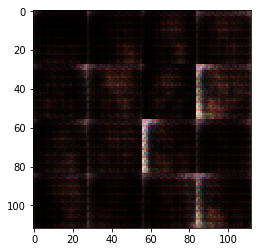

Epoch 1/1... Discriminator Loss: 0.7876... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 0.7186... Generator Loss: 1.0445
Epoch 1/1... Discriminator Loss: 0.4593... Generator Loss: 1.8150
Epoch 1/1... Discriminator Loss: 0.2876... Generator Loss: 3.7593
Epoch 1/1... Discriminator Loss: 0.7360... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 0.4120... Generator Loss: 2.0754
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 0.7527... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 0.2578... Generator Loss: 2.6920
Epoch 1/1... Discriminator Loss: 0.5759... Generator Loss: 2.0503


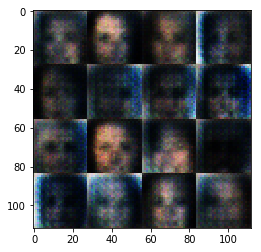

Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 4.3712
Epoch 1/1... Discriminator Loss: 2.3710... Generator Loss: 9.8035
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 0.5891... Generator Loss: 4.0736
Epoch 1/1... Discriminator Loss: 0.6893... Generator Loss: 3.1627
Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 1.2537
Epoch 1/1... Discriminator Loss: 0.4193... Generator Loss: 1.9025
Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 1.5022
Epoch 1/1... Discriminator Loss: 0.6818... Generator Loss: 1.3139
Epoch 1/1... Discriminator Loss: 1.6401... Generator Loss: 0.3394


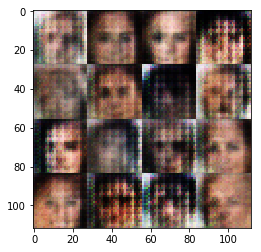

Epoch 1/1... Discriminator Loss: 0.7066... Generator Loss: 1.1538
Epoch 1/1... Discriminator Loss: 0.6390... Generator Loss: 1.3427
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 5.9608
Epoch 1/1... Discriminator Loss: 0.4691... Generator Loss: 2.1111
Epoch 1/1... Discriminator Loss: 2.1593... Generator Loss: 0.1788
Epoch 1/1... Discriminator Loss: 0.6036... Generator Loss: 1.3756
Epoch 1/1... Discriminator Loss: 0.6956... Generator Loss: 3.2478
Epoch 1/1... Discriminator Loss: 0.6304... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 0.5913... Generator Loss: 2.0905
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 0.8123


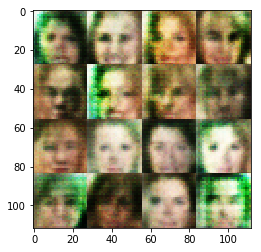

Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 3.7827
Epoch 1/1... Discriminator Loss: 0.7320... Generator Loss: 2.2244
Epoch 1/1... Discriminator Loss: 1.7674... Generator Loss: 5.8718
Epoch 1/1... Discriminator Loss: 1.9034... Generator Loss: 0.2838
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.4467
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 0.8293... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 0.7516... Generator Loss: 2.0105
Epoch 1/1... Discriminator Loss: 0.5021... Generator Loss: 2.1422
Epoch 1/1... Discriminator Loss: 0.6237... Generator Loss: 1.5141


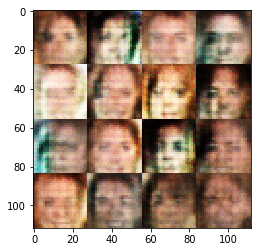

Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 0.7338... Generator Loss: 3.5183
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.5478
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 6.5927
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 0.9054... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 2.4423... Generator Loss: 0.1507
Epoch 1/1... Discriminator Loss: 0.3852... Generator Loss: 1.7292
Epoch 1/1... Discriminator Loss: 2.0148... Generator Loss: 0.2105
Epoch 1/1... Discriminator Loss: 0.6297... Generator Loss: 1.3635


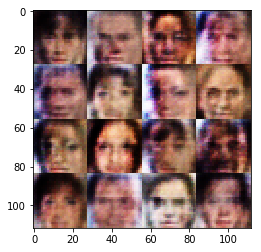

Epoch 1/1... Discriminator Loss: 0.1844... Generator Loss: 3.3803
Epoch 1/1... Discriminator Loss: 0.7764... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 2.0169
Epoch 1/1... Discriminator Loss: 0.3941... Generator Loss: 2.2213
Epoch 1/1... Discriminator Loss: 0.2599... Generator Loss: 2.8809
Epoch 1/1... Discriminator Loss: 0.3914... Generator Loss: 2.4872
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.3922
Epoch 1/1... Discriminator Loss: 2.9259... Generator Loss: 0.0852
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 1.1510
Epoch 1/1... Discriminator Loss: 0.8363... Generator Loss: 0.8918


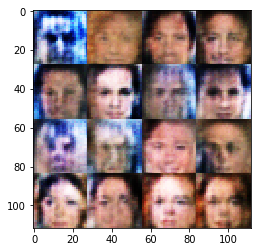

Epoch 1/1... Discriminator Loss: 0.5037... Generator Loss: 1.2823
Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 1.5114
Epoch 1/1... Discriminator Loss: 0.7632... Generator Loss: 1.5926
Epoch 1/1... Discriminator Loss: 0.2705... Generator Loss: 2.4617
Epoch 1/1... Discriminator Loss: 0.6424... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.4610
Epoch 1/1... Discriminator Loss: 0.4419... Generator Loss: 1.7029
Epoch 1/1... Discriminator Loss: 0.6173... Generator Loss: 1.9462
Epoch 1/1... Discriminator Loss: 1.6052... Generator Loss: 0.3043
Epoch 1/1... Discriminator Loss: 0.4873... Generator Loss: 1.5879


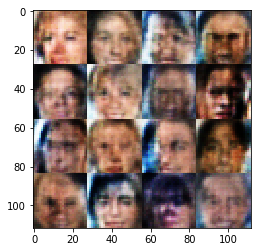

Epoch 1/1... Discriminator Loss: 0.1807... Generator Loss: 2.5579
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.3776
Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 2.0793
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 1.9287
Epoch 1/1... Discriminator Loss: 0.3292... Generator Loss: 2.1919
Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 0.1847... Generator Loss: 3.0474
Epoch 1/1... Discriminator Loss: 0.3331... Generator Loss: 1.9336
Epoch 1/1... Discriminator Loss: 0.7547... Generator Loss: 0.8713


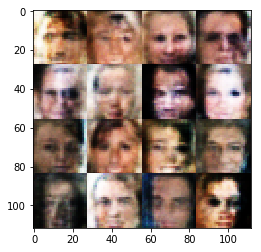

Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 4.1419
Epoch 1/1... Discriminator Loss: 0.5451... Generator Loss: 1.8098
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 4.4165
Epoch 1/1... Discriminator Loss: 0.3779... Generator Loss: 2.5052
Epoch 1/1... Discriminator Loss: 0.1028... Generator Loss: 3.9546
Epoch 1/1... Discriminator Loss: 0.7934... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 0.1572... Generator Loss: 5.9520
Epoch 1/1... Discriminator Loss: 0.3157... Generator Loss: 3.1478
Epoch 1/1... Discriminator Loss: 0.2807... Generator Loss: 2.3628
Epoch 1/1... Discriminator Loss: 0.2180... Generator Loss: 2.3790


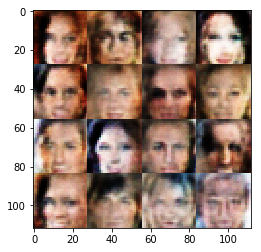

Epoch 1/1... Discriminator Loss: 0.3165... Generator Loss: 1.8919
Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 1.0574
Epoch 1/1... Discriminator Loss: 0.6516... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 0.5841... Generator Loss: 1.1647
Epoch 1/1... Discriminator Loss: 0.8054... Generator Loss: 4.0404
Epoch 1/1... Discriminator Loss: 0.1509... Generator Loss: 3.0991
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 0.6064... Generator Loss: 1.1278
Epoch 1/1... Discriminator Loss: 0.6599... Generator Loss: 2.0654
Epoch 1/1... Discriminator Loss: 0.6279... Generator Loss: 1.0235


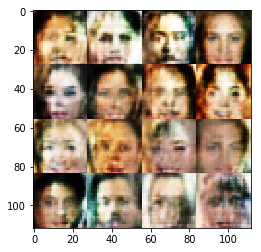

Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 5.7083
Epoch 1/1... Discriminator Loss: 0.4005... Generator Loss: 1.4470
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.4911
Epoch 1/1... Discriminator Loss: 0.5227... Generator Loss: 1.4558
Epoch 1/1... Discriminator Loss: 0.2944... Generator Loss: 2.2148
Epoch 1/1... Discriminator Loss: 0.1036... Generator Loss: 5.6112
Epoch 1/1... Discriminator Loss: 0.3699... Generator Loss: 1.7054
Epoch 1/1... Discriminator Loss: 0.3422... Generator Loss: 2.4409
Epoch 1/1... Discriminator Loss: 0.2856... Generator Loss: 1.9550
Epoch 1/1... Discriminator Loss: 0.2098... Generator Loss: 2.2413


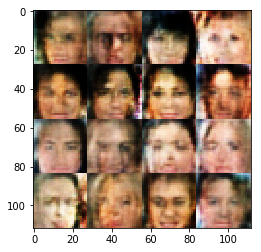

Epoch 1/1... Discriminator Loss: 0.6108... Generator Loss: 2.7190
Epoch 1/1... Discriminator Loss: 0.2362... Generator Loss: 3.6235
Epoch 1/1... Discriminator Loss: 1.8888... Generator Loss: 0.2589
Epoch 1/1... Discriminator Loss: 1.6330... Generator Loss: 5.0175
Epoch 1/1... Discriminator Loss: 0.8089... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 0.4997... Generator Loss: 3.7387
Epoch 1/1... Discriminator Loss: 0.0764... Generator Loss: 6.4220
Epoch 1/1... Discriminator Loss: 0.5801... Generator Loss: 1.5450
Epoch 1/1... Discriminator Loss: 0.2051... Generator Loss: 2.8207
Epoch 1/1... Discriminator Loss: 0.5587... Generator Loss: 1.1562


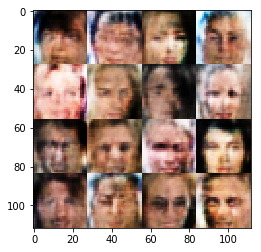

Epoch 1/1... Discriminator Loss: 0.6403... Generator Loss: 1.0853
Epoch 1/1... Discriminator Loss: 0.4884... Generator Loss: 3.5283
Epoch 1/1... Discriminator Loss: 0.2506... Generator Loss: 2.0370
Epoch 1/1... Discriminator Loss: 0.1698... Generator Loss: 2.5129
Epoch 1/1... Discriminator Loss: 0.4956... Generator Loss: 1.6675
Epoch 1/1... Discriminator Loss: 0.2438... Generator Loss: 3.8871
Epoch 1/1... Discriminator Loss: 0.2431... Generator Loss: 2.5060
Epoch 1/1... Discriminator Loss: 0.1970... Generator Loss: 4.1315
Epoch 1/1... Discriminator Loss: 0.0516... Generator Loss: 4.9140
Epoch 1/1... Discriminator Loss: 0.1214... Generator Loss: 3.5216


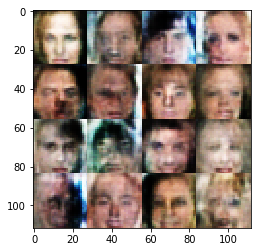

Epoch 1/1... Discriminator Loss: 2.6772... Generator Loss: 0.1121
Epoch 1/1... Discriminator Loss: 0.6875... Generator Loss: 1.0606
Epoch 1/1... Discriminator Loss: 0.1777... Generator Loss: 3.4628
Epoch 1/1... Discriminator Loss: 1.5328... Generator Loss: 0.3988
Epoch 1/1... Discriminator Loss: 0.3589... Generator Loss: 1.7992
Epoch 1/1... Discriminator Loss: 0.4069... Generator Loss: 2.3077
Epoch 1/1... Discriminator Loss: 2.3748... Generator Loss: 0.2193
Epoch 1/1... Discriminator Loss: 0.7286... Generator Loss: 1.1490
Epoch 1/1... Discriminator Loss: 0.5759... Generator Loss: 1.3321
Epoch 1/1... Discriminator Loss: 0.3360... Generator Loss: 2.1769


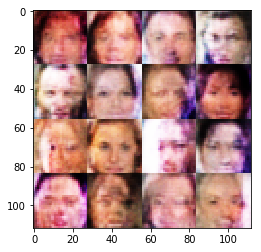

Epoch 1/1... Discriminator Loss: 0.2571... Generator Loss: 2.8562
Epoch 1/1... Discriminator Loss: 0.6852... Generator Loss: 2.1241
Epoch 1/1... Discriminator Loss: 0.1030... Generator Loss: 3.3622
Epoch 1/1... Discriminator Loss: 0.1116... Generator Loss: 3.3904
Epoch 1/1... Discriminator Loss: 0.2346... Generator Loss: 2.3572
Epoch 1/1... Discriminator Loss: 0.1290... Generator Loss: 4.2575
Epoch 1/1... Discriminator Loss: 0.6852... Generator Loss: 2.9621
Epoch 1/1... Discriminator Loss: 0.5657... Generator Loss: 1.4591
Epoch 1/1... Discriminator Loss: 0.5789... Generator Loss: 1.0577
Epoch 1/1... Discriminator Loss: 0.5404... Generator Loss: 1.9686


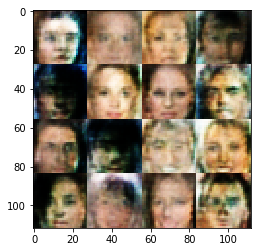

Epoch 1/1... Discriminator Loss: 0.1134... Generator Loss: 3.4465
Epoch 1/1... Discriminator Loss: 2.2042... Generator Loss: 8.8637
Epoch 1/1... Discriminator Loss: 0.4631... Generator Loss: 1.3841
Epoch 1/1... Discriminator Loss: 0.4347... Generator Loss: 2.7592
Epoch 1/1... Discriminator Loss: 0.4749... Generator Loss: 1.3667
Epoch 1/1... Discriminator Loss: 0.3684... Generator Loss: 2.5713
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 0.2118... Generator Loss: 2.2659
Epoch 1/1... Discriminator Loss: 0.3994... Generator Loss: 1.4647
Epoch 1/1... Discriminator Loss: 0.2341... Generator Loss: 1.9901


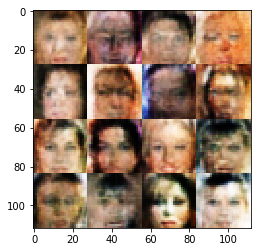

Epoch 1/1... Discriminator Loss: 0.5983... Generator Loss: 1.0377
Epoch 1/1... Discriminator Loss: 0.2911... Generator Loss: 1.8705
Epoch 1/1... Discriminator Loss: 0.1258... Generator Loss: 4.2477
Epoch 1/1... Discriminator Loss: 0.8050... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 0.0456... Generator Loss: 4.8737
Epoch 1/1... Discriminator Loss: 0.2056... Generator Loss: 2.4481
Epoch 1/1... Discriminator Loss: 0.2585... Generator Loss: 3.6474
Epoch 1/1... Discriminator Loss: 0.0385... Generator Loss: 4.6466
Epoch 1/1... Discriminator Loss: 0.2915... Generator Loss: 3.5751
Epoch 1/1... Discriminator Loss: 0.1458... Generator Loss: 2.8623


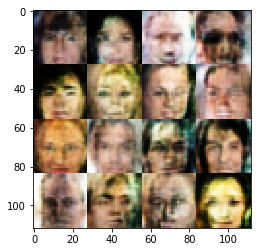

Epoch 1/1... Discriminator Loss: 4.2996... Generator Loss: 8.8228
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 0.6943... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 0.1532... Generator Loss: 3.2229
Epoch 1/1... Discriminator Loss: 0.1623... Generator Loss: 2.7101
Epoch 1/1... Discriminator Loss: 0.2774... Generator Loss: 1.9056
Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 0.3703... Generator Loss: 5.3199
Epoch 1/1... Discriminator Loss: 0.2723... Generator Loss: 1.9180
Epoch 1/1... Discriminator Loss: 0.0867... Generator Loss: 5.0000


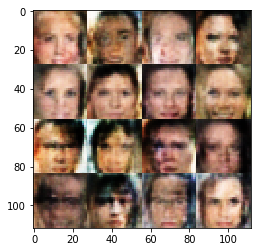

Epoch 1/1... Discriminator Loss: 0.2841... Generator Loss: 1.8018
Epoch 1/1... Discriminator Loss: 0.1262... Generator Loss: 3.4861
Epoch 1/1... Discriminator Loss: 0.0211... Generator Loss: 6.7159
Epoch 1/1... Discriminator Loss: 0.1603... Generator Loss: 2.3404
Epoch 1/1... Discriminator Loss: 0.0863... Generator Loss: 5.5104
Epoch 1/1... Discriminator Loss: 0.1025... Generator Loss: 2.7195
Epoch 1/1... Discriminator Loss: 0.0914... Generator Loss: 4.3147
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 0.0785... Generator Loss: 5.3984
Epoch 1/1... Discriminator Loss: 0.0621... Generator Loss: 5.2837


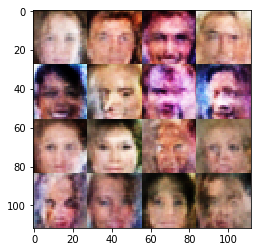

Epoch 1/1... Discriminator Loss: 0.0786... Generator Loss: 3.2456
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 0.7211... Generator Loss: 1.0635
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 0.0512... Generator Loss: 3.5982
Epoch 1/1... Discriminator Loss: 0.4073... Generator Loss: 1.4230
Epoch 1/1... Discriminator Loss: 0.3411... Generator Loss: 1.7573
Epoch 1/1... Discriminator Loss: 0.2914... Generator Loss: 2.1870
Epoch 1/1... Discriminator Loss: 0.8400... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 4.5421... Generator Loss: 0.0432


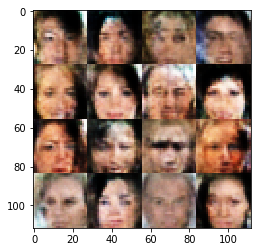

Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 1.9675
Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 3.3028
Epoch 1/1... Discriminator Loss: 2.2721... Generator Loss: 0.1741
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 0.4453... Generator Loss: 1.6583
Epoch 1/1... Discriminator Loss: 0.4082... Generator Loss: 1.6998
Epoch 1/1... Discriminator Loss: 0.1618... Generator Loss: 4.6102
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.5146


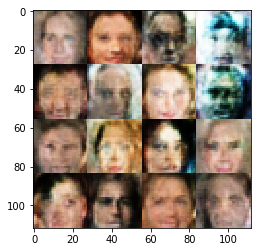

Epoch 1/1... Discriminator Loss: 0.4390... Generator Loss: 1.9511
Epoch 1/1... Discriminator Loss: 0.2288... Generator Loss: 2.0338
Epoch 1/1... Discriminator Loss: 0.4250... Generator Loss: 1.5537
Epoch 1/1... Discriminator Loss: 0.2327... Generator Loss: 1.9635
Epoch 1/1... Discriminator Loss: 0.2284... Generator Loss: 2.4322
Epoch 1/1... Discriminator Loss: 0.4336... Generator Loss: 1.4335
Epoch 1/1... Discriminator Loss: 0.3301... Generator Loss: 3.1106
Epoch 1/1... Discriminator Loss: 0.2268... Generator Loss: 2.0028
Epoch 1/1... Discriminator Loss: 0.2725... Generator Loss: 1.9133
Epoch 1/1... Discriminator Loss: 0.0979... Generator Loss: 4.6699


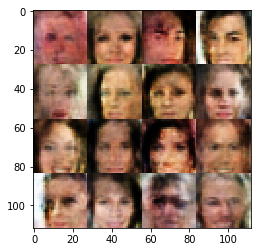

Epoch 1/1... Discriminator Loss: 0.4990... Generator Loss: 1.1569
Epoch 1/1... Discriminator Loss: 0.7406... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 0.4383... Generator Loss: 1.3346
Epoch 1/1... Discriminator Loss: 0.1161... Generator Loss: 3.2916
Epoch 1/1... Discriminator Loss: 0.4354... Generator Loss: 1.3096
Epoch 1/1... Discriminator Loss: 0.2686... Generator Loss: 1.7451
Epoch 1/1... Discriminator Loss: 0.2285... Generator Loss: 1.8537
Epoch 1/1... Discriminator Loss: 0.3216... Generator Loss: 2.2846
Epoch 1/1... Discriminator Loss: 0.0373... Generator Loss: 4.6402
Epoch 1/1... Discriminator Loss: 3.8930... Generator Loss: 10.8637


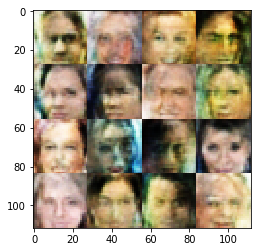

Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 3.7135
Epoch 1/1... Discriminator Loss: 0.4268... Generator Loss: 2.4127
Epoch 1/1... Discriminator Loss: 0.5176... Generator Loss: 1.4556
Epoch 1/1... Discriminator Loss: 0.3480... Generator Loss: 3.9491
Epoch 1/1... Discriminator Loss: 0.2055... Generator Loss: 4.8652
Epoch 1/1... Discriminator Loss: 0.1067... Generator Loss: 2.9800
Epoch 1/1... Discriminator Loss: 0.3088... Generator Loss: 1.6226
Epoch 1/1... Discriminator Loss: 0.1967... Generator Loss: 2.6750
Epoch 1/1... Discriminator Loss: 0.0844... Generator Loss: 3.3262
Epoch 1/1... Discriminator Loss: 1.7723... Generator Loss: 0.2546


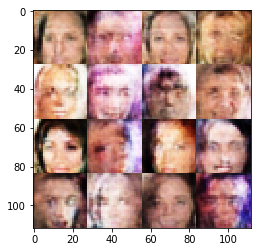

Epoch 1/1... Discriminator Loss: 0.2500... Generator Loss: 2.2757
Epoch 1/1... Discriminator Loss: 0.1568... Generator Loss: 2.7805
Epoch 1/1... Discriminator Loss: 0.2703... Generator Loss: 3.7274
Epoch 1/1... Discriminator Loss: 0.0544... Generator Loss: 4.0680
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 3.8993
Epoch 1/1... Discriminator Loss: 0.1004... Generator Loss: 3.0587
Epoch 1/1... Discriminator Loss: 0.0290... Generator Loss: 6.2678
Epoch 1/1... Discriminator Loss: 0.5948... Generator Loss: 3.8936
Epoch 1/1... Discriminator Loss: 0.1722... Generator Loss: 2.5561
Epoch 1/1... Discriminator Loss: 0.1564... Generator Loss: 2.4547


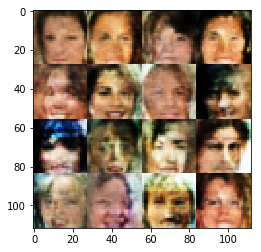

Epoch 1/1... Discriminator Loss: 0.1020... Generator Loss: 3.2154
Epoch 1/1... Discriminator Loss: 0.2086... Generator Loss: 2.1024
Epoch 1/1... Discriminator Loss: 0.0968... Generator Loss: 3.4785
Epoch 1/1... Discriminator Loss: 0.0149... Generator Loss: 5.0595
Epoch 1/1... Discriminator Loss: 2.7086... Generator Loss: 0.1171
Epoch 1/1... Discriminator Loss: 0.4245... Generator Loss: 1.8369
Epoch 1/1... Discriminator Loss: 0.5441... Generator Loss: 1.2381
Epoch 1/1... Discriminator Loss: 0.2819... Generator Loss: 2.7535
Epoch 1/1... Discriminator Loss: 0.4615... Generator Loss: 1.2719
Epoch 1/1... Discriminator Loss: 0.0527... Generator Loss: 7.2176


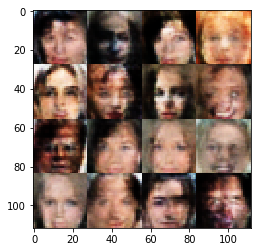

Epoch 1/1... Discriminator Loss: 0.1016... Generator Loss: 3.8429
Epoch 1/1... Discriminator Loss: 0.0805... Generator Loss: 4.6771
Epoch 1/1... Discriminator Loss: 0.0371... Generator Loss: 5.1502
Epoch 1/1... Discriminator Loss: 0.0333... Generator Loss: 4.8870
Epoch 1/1... Discriminator Loss: 0.2250... Generator Loss: 2.3961
Epoch 1/1... Discriminator Loss: 0.0737... Generator Loss: 6.1816
Epoch 1/1... Discriminator Loss: 0.2534... Generator Loss: 1.9673
Epoch 1/1... Discriminator Loss: 0.1372... Generator Loss: 4.5347
Epoch 1/1... Discriminator Loss: 0.1245... Generator Loss: 2.7868
Epoch 1/1... Discriminator Loss: 0.1228... Generator Loss: 2.7031


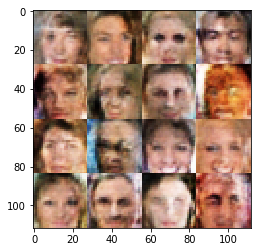

Epoch 1/1... Discriminator Loss: 0.0562... Generator Loss: 3.9934
Epoch 1/1... Discriminator Loss: 0.0445... Generator Loss: 3.9865
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.4053
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 5.5469
Epoch 1/1... Discriminator Loss: 1.9321... Generator Loss: 4.5446
Epoch 1/1... Discriminator Loss: 0.5040... Generator Loss: 1.4612
Epoch 1/1... Discriminator Loss: 0.3369... Generator Loss: 2.4440
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.3820
Epoch 1/1... Discriminator Loss: 0.3861... Generator Loss: 1.9252
Epoch 1/1... Discriminator Loss: 0.3674... Generator Loss: 1.5024


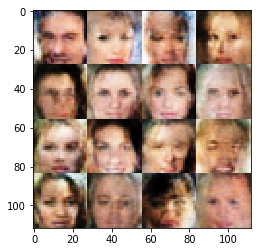

Epoch 1/1... Discriminator Loss: 0.1597... Generator Loss: 3.7265
Epoch 1/1... Discriminator Loss: 0.1492... Generator Loss: 4.1559
Epoch 1/1... Discriminator Loss: 0.5823... Generator Loss: 1.2470
Epoch 1/1... Discriminator Loss: 0.1778... Generator Loss: 2.5330
Epoch 1/1... Discriminator Loss: 0.6670... Generator Loss: 1.0152
Epoch 1/1... Discriminator Loss: 0.1154... Generator Loss: 3.3140


In [27]:
batch_size = 64
z_dim = 100
learning_rate = .0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

# Training using approach 2 where inner loop (discriminator) runs several times (10) before one update of generator
## Run the cell under approach 2 before running this cell
## Implement using approach 2

Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 2.7260... Generator Loss: 0.2355
Epoch 1/1... Discriminator Loss: 0.0015... Generator Loss: 8.1290
Epoch 1/1... Discriminator Loss: 0.0127... Generator Loss: 4.8864
Epoch 1/1... Discriminator Loss: 0.0056... Generator Loss: 5.7185
Epoch 1/1... Discriminator Loss: 0.0240... Generator Loss: 4.3691
Epoch 1/1... Discriminator Loss: 0.3414... Generator Loss: 7.3199
Epoch 1/1... Discriminator Loss: 0.2164... Generator Loss: 3.0934
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 0.0096... Generator Loss: 5.8182


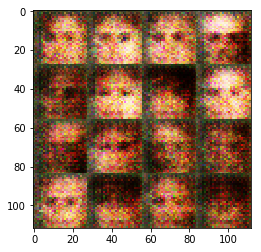

Epoch 1/1... Discriminator Loss: 0.0283... Generator Loss: 6.5866
Epoch 1/1... Discriminator Loss: 0.2132... Generator Loss: 2.2475
Epoch 1/1... Discriminator Loss: 0.0305... Generator Loss: 4.0470
Epoch 1/1... Discriminator Loss: 0.1347... Generator Loss: 2.7722
Epoch 1/1... Discriminator Loss: 0.0560... Generator Loss: 5.1624
Epoch 1/1... Discriminator Loss: 0.3707... Generator Loss: 1.9878
Epoch 1/1... Discriminator Loss: 0.2851... Generator Loss: 2.5420
Epoch 1/1... Discriminator Loss: 0.3698... Generator Loss: 1.5773
Epoch 1/1... Discriminator Loss: 0.1385... Generator Loss: 3.7113
Epoch 1/1... Discriminator Loss: 0.2429... Generator Loss: 2.2341


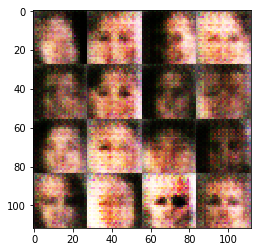

Epoch 1/1... Discriminator Loss: 0.0925... Generator Loss: 3.9760
Epoch 1/1... Discriminator Loss: 0.4909... Generator Loss: 1.8310
Epoch 1/1... Discriminator Loss: 0.1305... Generator Loss: 5.3175
Epoch 1/1... Discriminator Loss: 0.1194... Generator Loss: 3.6742
Epoch 1/1... Discriminator Loss: 0.7890... Generator Loss: 0.9556
Epoch 1/1... Discriminator Loss: 0.1484... Generator Loss: 3.1769
Epoch 1/1... Discriminator Loss: 0.2705... Generator Loss: 2.1448
Epoch 1/1... Discriminator Loss: 0.4516... Generator Loss: 1.5531
Epoch 1/1... Discriminator Loss: 0.5961... Generator Loss: 1.4017
Epoch 1/1... Discriminator Loss: 2.1025... Generator Loss: 0.4240


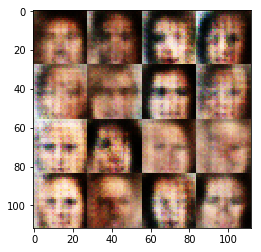

Epoch 1/1... Discriminator Loss: 0.3575... Generator Loss: 1.7407
Epoch 1/1... Discriminator Loss: 0.2750... Generator Loss: 2.1825
Epoch 1/1... Discriminator Loss: 0.4761... Generator Loss: 1.9311
Epoch 1/1... Discriminator Loss: 0.5715... Generator Loss: 1.3734
Epoch 1/1... Discriminator Loss: 0.4749... Generator Loss: 1.7396
Epoch 1/1... Discriminator Loss: 0.2654... Generator Loss: 1.9260
Epoch 1/1... Discriminator Loss: 0.7856... Generator Loss: 1.1338
Epoch 1/1... Discriminator Loss: 0.0938... Generator Loss: 3.1025
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 0.3553... Generator Loss: 1.5862


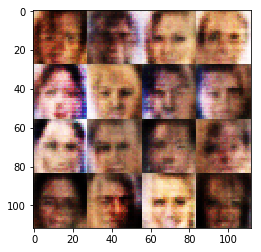

Epoch 1/1... Discriminator Loss: 0.6511... Generator Loss: 1.2021
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 0.2944... Generator Loss: 2.0587
Epoch 1/1... Discriminator Loss: 0.0644... Generator Loss: 3.7550
Epoch 1/1... Discriminator Loss: 0.0823... Generator Loss: 3.6208
Epoch 1/1... Discriminator Loss: 0.1937... Generator Loss: 2.4048
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 0.2220... Generator Loss: 2.6228
Epoch 1/1... Discriminator Loss: 0.3279... Generator Loss: 1.8790
Epoch 1/1... Discriminator Loss: 0.0561... Generator Loss: 3.7765


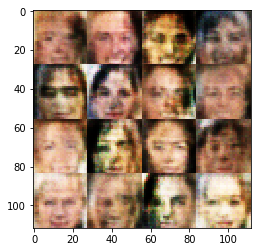

Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 8.0843
Epoch 1/1... Discriminator Loss: 0.2845... Generator Loss: 2.1028
Epoch 1/1... Discriminator Loss: 0.0780... Generator Loss: 3.2709
Epoch 1/1... Discriminator Loss: 0.0177... Generator Loss: 5.0626
Epoch 1/1... Discriminator Loss: 0.0185... Generator Loss: 4.6505
Epoch 1/1... Discriminator Loss: 0.0847... Generator Loss: 3.1475
Epoch 1/1... Discriminator Loss: 0.1334... Generator Loss: 3.0140
Epoch 1/1... Discriminator Loss: 0.6012... Generator Loss: 1.5234
Epoch 1/1... Discriminator Loss: 0.0238... Generator Loss: 4.4540
Epoch 1/1... Discriminator Loss: 0.0355... Generator Loss: 4.0322


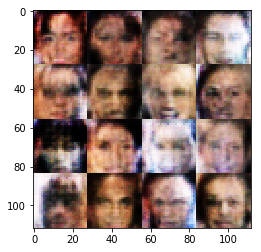

Epoch 1/1... Discriminator Loss: 0.0996... Generator Loss: 3.3488
Epoch 1/1... Discriminator Loss: 0.2898... Generator Loss: 2.0780
Epoch 1/1... Discriminator Loss: 0.0675... Generator Loss: 3.6179
Epoch 1/1... Discriminator Loss: 0.0474... Generator Loss: 3.8789
Epoch 1/1... Discriminator Loss: 0.5748... Generator Loss: 1.5693
Epoch 1/1... Discriminator Loss: 0.1908... Generator Loss: 2.4623
Epoch 1/1... Discriminator Loss: 0.3048... Generator Loss: 2.4136
Epoch 1/1... Discriminator Loss: 0.0219... Generator Loss: 4.7616
Epoch 1/1... Discriminator Loss: 0.0068... Generator Loss: 6.3180
Epoch 1/1... Discriminator Loss: 0.0035... Generator Loss: 6.7295


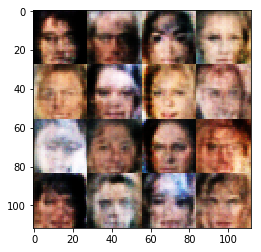

Epoch 1/1... Discriminator Loss: 0.0052... Generator Loss: 6.4846
Epoch 1/1... Discriminator Loss: 0.0442... Generator Loss: 3.8261
Epoch 1/1... Discriminator Loss: 0.2805... Generator Loss: 2.1603
Epoch 1/1... Discriminator Loss: 0.0827... Generator Loss: 3.4139
Epoch 1/1... Discriminator Loss: 0.4946... Generator Loss: 1.4953
Epoch 1/1... Discriminator Loss: 0.2684... Generator Loss: 2.2152
Epoch 1/1... Discriminator Loss: 0.3397... Generator Loss: 1.9849
Epoch 1/1... Discriminator Loss: 0.1824... Generator Loss: 2.3807
Epoch 1/1... Discriminator Loss: 0.1859... Generator Loss: 2.3713
Epoch 1/1... Discriminator Loss: 0.2446... Generator Loss: 2.1331


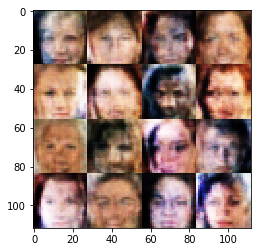

Epoch 1/1... Discriminator Loss: 0.0688... Generator Loss: 3.5869
Epoch 1/1... Discriminator Loss: 0.2521... Generator Loss: 2.0990
Epoch 1/1... Discriminator Loss: 0.0963... Generator Loss: 3.5792
Epoch 1/1... Discriminator Loss: 0.0974... Generator Loss: 3.5582
Epoch 1/1... Discriminator Loss: 0.3611... Generator Loss: 1.5548
Epoch 1/1... Discriminator Loss: 0.0112... Generator Loss: 5.7985
Epoch 1/1... Discriminator Loss: 0.0519... Generator Loss: 3.6538
Epoch 1/1... Discriminator Loss: 2.2852... Generator Loss: 0.2633
Epoch 1/1... Discriminator Loss: 0.0104... Generator Loss: 5.5104
Epoch 1/1... Discriminator Loss: 0.0029... Generator Loss: 11.5409


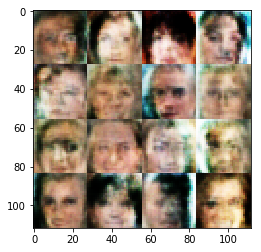

Epoch 1/1... Discriminator Loss: 0.0177... Generator Loss: 4.8836
Epoch 1/1... Discriminator Loss: 0.1788... Generator Loss: 2.8206
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 13.3937
Epoch 1/1... Discriminator Loss: 0.5803... Generator Loss: 1.3872
Epoch 1/1... Discriminator Loss: 0.3471... Generator Loss: 1.7395
Epoch 1/1... Discriminator Loss: 0.0223... Generator Loss: 4.6278
Epoch 1/1... Discriminator Loss: 0.0640... Generator Loss: 3.4145
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 0.0861... Generator Loss: 3.3352
Epoch 1/1... Discriminator Loss: 0.2006... Generator Loss: 2.7204


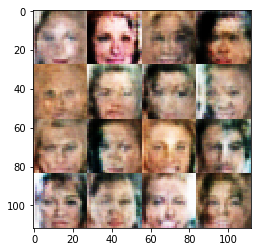

Epoch 1/1... Discriminator Loss: 0.0406... Generator Loss: 3.8879
Epoch 1/1... Discriminator Loss: 0.1200... Generator Loss: 2.7894
Epoch 1/1... Discriminator Loss: 0.0025... Generator Loss: 7.8755
Epoch 1/1... Discriminator Loss: 0.0119... Generator Loss: 5.3514
Epoch 1/1... Discriminator Loss: 0.0381... Generator Loss: 4.0142
Epoch 1/1... Discriminator Loss: 0.0110... Generator Loss: 5.6215
Epoch 1/1... Discriminator Loss: 0.0960... Generator Loss: 3.4959
Epoch 1/1... Discriminator Loss: 0.4371... Generator Loss: 1.3815
Epoch 1/1... Discriminator Loss: 0.0154... Generator Loss: 4.9720
Epoch 1/1... Discriminator Loss: 0.2326... Generator Loss: 2.3717


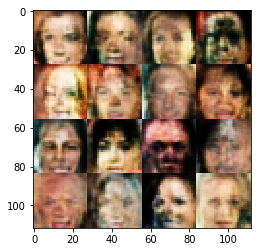

Epoch 1/1... Discriminator Loss: 0.2197... Generator Loss: 2.0813
Epoch 1/1... Discriminator Loss: 0.1151... Generator Loss: 2.9218
Epoch 1/1... Discriminator Loss: 0.0214... Generator Loss: 4.6392
Epoch 1/1... Discriminator Loss: 0.0200... Generator Loss: 5.1484
Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 7.7904
Epoch 1/1... Discriminator Loss: 0.4527... Generator Loss: 1.3774
Epoch 1/1... Discriminator Loss: 0.0874... Generator Loss: 3.3011
Epoch 1/1... Discriminator Loss: 0.0172... Generator Loss: 4.9900
Epoch 1/1... Discriminator Loss: 0.8488... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 0.9773


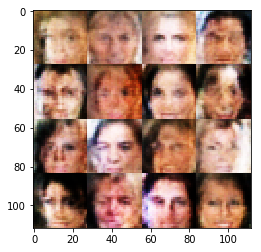

Epoch 1/1... Discriminator Loss: 0.0549... Generator Loss: 3.5759
Epoch 1/1... Discriminator Loss: 0.0327... Generator Loss: 4.8154
Epoch 1/1... Discriminator Loss: 0.1940... Generator Loss: 2.1912
Epoch 1/1... Discriminator Loss: 0.8609... Generator Loss: 1.0122
Epoch 1/1... Discriminator Loss: 0.0072... Generator Loss: 5.8797
Epoch 1/1... Discriminator Loss: 0.5383... Generator Loss: 1.6915
Epoch 1/1... Discriminator Loss: 0.5809... Generator Loss: 1.2522
Epoch 1/1... Discriminator Loss: 0.1420... Generator Loss: 2.7041
Epoch 1/1... Discriminator Loss: 0.0193... Generator Loss: 4.8376
Epoch 1/1... Discriminator Loss: 0.0148... Generator Loss: 5.6637


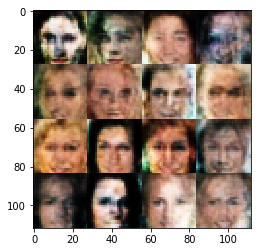

Epoch 1/1... Discriminator Loss: 1.9470... Generator Loss: 0.3071
Epoch 1/1... Discriminator Loss: 0.0222... Generator Loss: 4.5018
Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 8.6822
Epoch 1/1... Discriminator Loss: 0.4779... Generator Loss: 1.4669
Epoch 1/1... Discriminator Loss: 0.2295... Generator Loss: 2.3498
Epoch 1/1... Discriminator Loss: 0.4380... Generator Loss: 2.0040
Epoch 1/1... Discriminator Loss: 0.2179... Generator Loss: 2.1716
Epoch 1/1... Discriminator Loss: 0.0440... Generator Loss: 4.4265
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 1.3671
Epoch 1/1... Discriminator Loss: 0.0548... Generator Loss: 3.9286


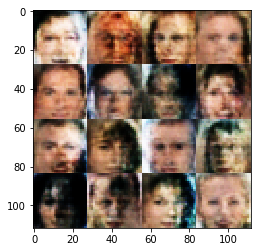

Epoch 1/1... Discriminator Loss: 0.5622... Generator Loss: 1.4655
Epoch 1/1... Discriminator Loss: 0.0067... Generator Loss: 7.4594
Epoch 1/1... Discriminator Loss: 0.6548... Generator Loss: 1.2340
Epoch 1/1... Discriminator Loss: 0.0087... Generator Loss: 5.7742
Epoch 1/1... Discriminator Loss: 0.0102... Generator Loss: 5.5244
Epoch 1/1... Discriminator Loss: 0.0031... Generator Loss: 6.6500
Epoch 1/1... Discriminator Loss: 0.0016... Generator Loss: 9.4063
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 12.1213
Epoch 1/1... Discriminator Loss: 0.0017... Generator Loss: 8.7009
Epoch 1/1... Discriminator Loss: 0.2040... Generator Loss: 2.0575


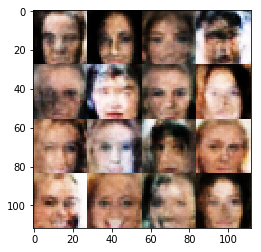

Epoch 1/1... Discriminator Loss: 0.1164... Generator Loss: 2.6983
Epoch 1/1... Discriminator Loss: 0.2356... Generator Loss: 2.0294
Epoch 1/1... Discriminator Loss: 0.0493... Generator Loss: 3.9710
Epoch 1/1... Discriminator Loss: 0.0201... Generator Loss: 4.9525
Epoch 1/1... Discriminator Loss: 0.0150... Generator Loss: 4.9615
Epoch 1/1... Discriminator Loss: 0.0271... Generator Loss: 4.4567
Epoch 1/1... Discriminator Loss: 0.0176... Generator Loss: 4.9525
Epoch 1/1... Discriminator Loss: 0.0708... Generator Loss: 4.6981
Epoch 1/1... Discriminator Loss: 0.4807... Generator Loss: 1.9268
Epoch 1/1... Discriminator Loss: 0.1611... Generator Loss: 2.8497


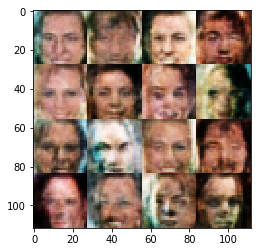

Epoch 1/1... Discriminator Loss: 0.0765... Generator Loss: 3.8425
Epoch 1/1... Discriminator Loss: 0.0017... Generator Loss: 9.0989
Epoch 1/1... Discriminator Loss: 0.0017... Generator Loss: 8.8675
Epoch 1/1... Discriminator Loss: 0.0029... Generator Loss: 7.1417
Epoch 1/1... Discriminator Loss: 0.0792... Generator Loss: 3.2974
Epoch 1/1... Discriminator Loss: 0.0677... Generator Loss: 3.1768
Epoch 1/1... Discriminator Loss: 0.0249... Generator Loss: 5.3660
Epoch 1/1... Discriminator Loss: 0.3009... Generator Loss: 2.0244
Epoch 1/1... Discriminator Loss: 0.0193... Generator Loss: 5.0602
Epoch 1/1... Discriminator Loss: 0.0064... Generator Loss: 6.1698


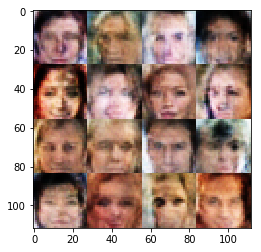

Epoch 1/1... Discriminator Loss: 0.1724... Generator Loss: 2.3409
Epoch 1/1... Discriminator Loss: 0.5620... Generator Loss: 1.4091
Epoch 1/1... Discriminator Loss: 0.4201... Generator Loss: 1.8215
Epoch 1/1... Discriminator Loss: 0.3148... Generator Loss: 2.0388
Epoch 1/1... Discriminator Loss: 0.0328... Generator Loss: 4.4697
Epoch 1/1... Discriminator Loss: 0.0987... Generator Loss: 3.0012
Epoch 1/1... Discriminator Loss: 0.0875... Generator Loss: 3.3867
Epoch 1/1... Discriminator Loss: 0.0068... Generator Loss: 7.9005
Epoch 1/1... Discriminator Loss: 0.8429... Generator Loss: 1.2076
Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 8.3171


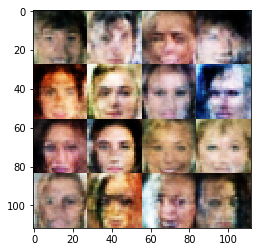

Epoch 1/1... Discriminator Loss: 0.3380... Generator Loss: 1.8282
Epoch 1/1... Discriminator Loss: 0.0757... Generator Loss: 3.5521
Epoch 1/1... Discriminator Loss: 0.0144... Generator Loss: 5.0576
Epoch 1/1... Discriminator Loss: 0.0793... Generator Loss: 3.4993
Epoch 1/1... Discriminator Loss: 0.0048... Generator Loss: 6.1765
Epoch 1/1... Discriminator Loss: 0.0025... Generator Loss: 7.4646
Epoch 1/1... Discriminator Loss: 0.0036... Generator Loss: 8.3338
Epoch 1/1... Discriminator Loss: 0.2548... Generator Loss: 2.1602
Epoch 1/1... Discriminator Loss: 0.0169... Generator Loss: 4.8441
Epoch 1/1... Discriminator Loss: 0.0653... Generator Loss: 3.4902


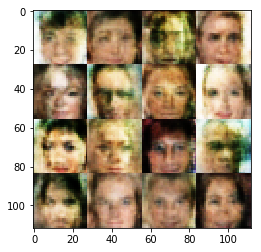

Epoch 1/1... Discriminator Loss: 0.0149... Generator Loss: 5.4620
Epoch 1/1... Discriminator Loss: 0.0039... Generator Loss: 7.7057
Epoch 1/1... Discriminator Loss: 0.6302... Generator Loss: 2.0801
Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 1.2654
Epoch 1/1... Discriminator Loss: 0.3454... Generator Loss: 2.3819
Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 1.9312
Epoch 1/1... Discriminator Loss: 0.0050... Generator Loss: 6.6464
Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 8.6104
Epoch 1/1... Discriminator Loss: 0.0026... Generator Loss: 6.7247


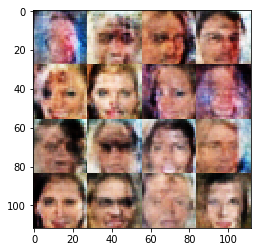

Epoch 1/1... Discriminator Loss: 0.0354... Generator Loss: 4.2158
Epoch 1/1... Discriminator Loss: 0.4837... Generator Loss: 1.7071
Epoch 1/1... Discriminator Loss: 0.2181... Generator Loss: 3.1152
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 1.3059
Epoch 1/1... Discriminator Loss: 0.1227... Generator Loss: 2.7578
Epoch 1/1... Discriminator Loss: 0.0933... Generator Loss: 3.1628
Epoch 1/1... Discriminator Loss: 0.0040... Generator Loss: 7.0778
Epoch 1/1... Discriminator Loss: 0.1730... Generator Loss: 2.7563
Epoch 1/1... Discriminator Loss: 0.0902... Generator Loss: 5.7385
Epoch 1/1... Discriminator Loss: 0.1851... Generator Loss: 2.5819


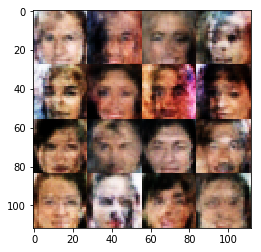

Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 8.8807


KeyboardInterrupt: 

In [29]:
batch_size = 64
z_dim = 100
learning_rate = .0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.